# 使用KV cache(Prefix cache)对计算量的影响

练习目标：
* 理解使用Prefix cache对计算量的影响

模型：prefill阶段，仅考虑Attention（MLA）模块和FFN（MoE）模块的flops计算，通过增加已计算的前缀缓存（Prefix Cache）长度获得算量的变化。


相关文章链接：

[高效推理的核心：vLLM V1 KV cache 管理机制剖析 第2节](https://zhuanlan.zhihu.com/p/1954128446398633139)

[vLLM的prefix cache为何零开销](https://zhuanlan.zhihu.com/p/1896927732027335111)



Author: kaiyuan

Email: kyxie@zju.edu.cn

## 1 模块计算公式定义

MLA-MHA模式（非吸收矩阵）

原理参考：[超细图解MLA计算流&吸收矩阵对比分析](https://zhuanlan.zhihu.com/p/1948769945132470860)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# MLA的相关参数，参考DeepSeekV3参数
bs = 1
heads = 128
qk_head_dim = 128
kv_lora_rank = 512
h_dim = 7168
q_lora_rank = 1536
qk_rope_head_dim = 64
v_head_dim = 128
n_heads = v_head_dim
causal_mask_cof = 2 # casual mask是否启用 开启等于2，关闭等于1
n_shared_experts = 1
n_routed_experts = 256
moe_inter_dim = 2048
n_activated_experts = 8

def convert_flops(flops, cof=1024 * 1024 * 1024):
    return flops / cof

In [ ]:
# MLA-MHA模式 计算公式:
def calc_mla_non_absorb_flops(seq_len, cache_len=0):
    q_down_proj = 2 * bs * seq_len * h_dim * q_lora_rank
    q_up_proj = 2 * bs * seq_len * q_lora_rank * heads * (qk_head_dim + qk_rope_head_dim)
    q_linear = q_down_proj + q_up_proj

    kv_down_proj = 2 * bs * seq_len * h_dim * (kv_lora_rank + qk_rope_head_dim)
    kv_up_proj = 2 * bs * heads * (seq_len + cache_len) * kv_lora_rank * (qk_head_dim + v_head_dim)
    kv_linear = kv_down_proj + kv_up_proj

    kv_scores = 2 * bs * heads * seq_len * (seq_len + cache_len) * (qk_head_dim + qk_rope_head_dim) / causal_mask_cof
    qkv = 2 * bs * heads * seq_len * (seq_len + cache_len) * v_head_dim / causal_mask_cof
    out = 2 * bs * seq_len * n_heads * v_head_dim * h_dim
    attention = kv_scores + qkv
    mla_non_absorb_flops = attention + kv_linear + q_linear + out
    return mla_non_absorb_flops, q_linear, kv_linear, attention, out
def calc_moe(seq_len):
    linear_layer_flops = 2 * 3 * bs * seq_len * h_dim * moe_inter_dim
    route_flops = 2 *  bs * seq_len * h_dim * n_routed_experts
    moe_layer_flops = linear_layer_flops * (n_shared_experts + n_activated_experts) + route_flops
    return moe_layer_flops

In [ ]:
# 测试函数：
print(calc_mla_non_absorb_flops(1, 2000))

(67565035520.0, 97517568, 67150675968, 81960960.0, 234881024)


## 2 图表绘制

In [ ]:
def plot_data(x, flops_with_kv_cache, flops_without_kv_cache, title = "MLA Prefill", xlable='prefix cache length'):

  # 创建图形
  plt.figure(figsize=(8, 4))
  plt.ylim(0, max(with_kv_cache_data) + 1000)

  # 绘制多条折线

  plt.plot(x, flops_with_kv_cache, label='with_kv_cache', marker='o')
  plt.plot(x, flops_without_kv_cache, label='without_kv_cache', marker='s')


  # 添加标题和标签
  plt.title(title)
  plt.xlabel(xlable)
  plt.ylabel('Gflops')

  # 添加图例
  plt.legend()

  # 显示网格
  plt.grid(True, linestyle='--', alpha=0.7)

  # 显示图形
  plt.show()

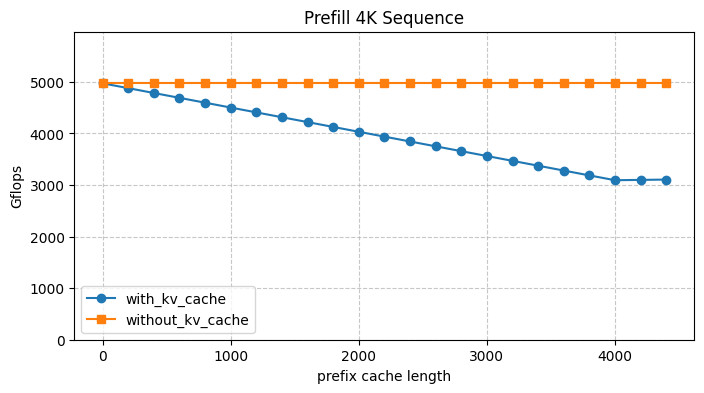

In [ ]:
seq_len = 4000 # 序列最大长度
x = []
with_kv_cache_data = []
without_kv_cache_data = []

# 逐步增加匹配的KV cache的长度：
for i in range(0, 4500, 200):
  with_kv_cache, _, _, attention, *_ = calc_mla_non_absorb_flops(max(seq_len - i, 1), i)
  without_kv_cache, *_ = calc_mla_non_absorb_flops(seq_len, 0)
  moe = calc_moe(seq_len)
  x.append(i)
  with_kv_cache_data.append(convert_flops(with_kv_cache + moe))
  without_kv_cache_data.append(convert_flops(without_kv_cache + moe))

plot_data(x, with_kv_cache_data, without_kv_cache_data, title = f"Prefill {seq_len//1000}K Sequence")